In [244]:
# Import packages

import pandas as pd 
import numpy as np 
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import plotly.express as px

import xgboost as xgb

from joblib import dump, load

pd.set_option('display.max_columns', None)

In [245]:
base = pd.read_csv('../data/adjusted_stats_modeling_base_df.csv')
model = load('../modeling/game_outcome_modeling/saved_models/random_forest_av.joblib')
feature_list = ['qb_adjusted_value_home', 'rushing_adjusted_value_home', 'qb_def_adjusted_value_home', 'rush_def_adjusted_value_home', 'special_teams_value_home',
                   'qb_adjusted_value_away', 'rushing_adjusted_value_away', 'qb_def_adjusted_value_away', 'rush_def_adjusted_value_away', 'special_teams_value_away']

In [246]:
# Get predictions and probabilites

base = base.dropna()
features = base[feature_list].to_numpy()

# Get win predictions/probabilities

win_preds = model.predict(features)
win_probs = model.predict_proba(features)

In [247]:
base['home_win_pred'] = win_preds
base['home_win_prob'] = win_probs[:,1]
base['away_win_prob'] = win_probs[:,0]

In [248]:
# Set what part of the data to analyze
# Most models will just look at the test set (2022 for now)
# For models with very low overfitting, could be fruitful to look at the results on the entire data set though

# analysis_df = base[base.season != 2022]
analysis_df = base[base.season == 2022]
analysis_df['pred_correct'] = analysis_df.apply(lambda x: 1 if x.home_win == x.home_win_pred else 0, axis=1)
analysis_df.head()

<ipython-input-248-1cc0db560be6>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,date,season,week,season_type,home,away,home_score,away_score,home_qb,away_qb,qb_adjusted_value_home,rushing_adjusted_value_home,qb_rushing_value_pct_home,qb_def_adjusted_value_home,rush_def_adjusted_value_home,special_teams_value_home,qb_adjusted_value_away,rushing_adjusted_value_away,qb_rushing_value_pct_away,qb_def_adjusted_value_away,rush_def_adjusted_value_away,special_teams_value_away,home_win,home_win_pred,home_win_prob,away_win_prob,pred_correct
2146,2154,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.846672,-1.526921,0.0,0.659332,0.013114,0.062338,1.331436,1.477956,0.0,0.389701,-0.461327,-0.118813,0,0,0.43,0.57,1
2147,2155,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.247191,-0.441563,0.0,0.815666,-0.619903,-0.147288,0.347370,0.498576,0.0,-0.329891,-1.202476,0.166116,1,1,0.62,0.38,1
2150,2158,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,-0.427333,-0.134352,0.0,-0.622903,-0.379120,0.396428,-0.429986,0.776442,0.0,-0.947986,0.157411,0.776423,0,0,0.39,0.61,1
2153,2161,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,-0.156866,-0.552323,0.0,-0.068564,-0.823399,0.029035,-0.047993,0.462513,0.0,-0.128524,-0.307588,-0.223404,0,1,0.63,0.37,0
2154,2162,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.562550,0.274953,0.0,0.275204,-0.295882,0.651611,-0.251743,-0.857999,0.0,0.118070,0.615457,0.262438,1,1,0.51,0.49,1


In [249]:
# Get general accuracy measurements

accuracy = accuracy_score(analysis_df.home_win, analysis_df.home_win_pred)
tn, fp, fn, tp = confusion_matrix(analysis_df.home_win, analysis_df.home_win_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print()
print('True Positive Rate: {}'.format(tp/(tp+fn)))
print('False Positive Rate: {}'.format(fp/(fp+tn)))
print('True Negative Rate: {}'.format(tn/(tn+fp)))
print('False Negative Rate: {}'.format(fn/(fn+tp)))

Accuracy: 0.6172839506172839
Precision: 0.6530612244897959
Recall: 0.6956521739130435

True Positive Rate: 0.6956521739130435
False Positive Rate: 0.4857142857142857
True Negative Rate: 0.5142857142857142
False Negative Rate: 0.30434782608695654


In [250]:
# Get NFL translated accuracy stats

home_win_pct = sum(analysis_df.home_win==1)/len(analysis_df)
away_win_pct = sum(analysis_df.home_win==0)/len(analysis_df)

home_win_pred_pct = sum(analysis_df.home_win_pred==1)/len(analysis_df)
away_win_pred_pct = sum(analysis_df.home_win_pred==0)/len(analysis_df)

print('Home Win Percentage: {}'.format(home_win_pct))
print('Away Win Percentage: {}'.format(away_win_pct))
print('Home Win Predicted Percentage: {}'.format(home_win_pred_pct))
print('Away Win Predicted Percentage: {}'.format(away_win_pred_pct))

Home Win Percentage: 0.5679012345679012
Away Win Percentage: 0.43209876543209874
Home Win Predicted Percentage: 0.6049382716049383
Away Win Predicted Percentage: 0.3950617283950617


In [251]:
home_wins = analysis_df[analysis_df.home_win==1]
away_wins = analysis_df[analysis_df.home_win==0]

home_win_acc = accuracy_score(home_wins.home_win, home_wins.home_win_pred)
away_win_acc = accuracy_score(away_wins.home_win, away_wins.home_win_pred)

home_wins_pred = analysis_df[analysis_df.home_win_pred==1]
away_wins_pred = analysis_df[analysis_df.home_win_pred==0]

home_win_pred_acc = accuracy_score(home_wins_pred.home_win, home_wins_pred.home_win_pred)
away_win_pred_acc = accuracy_score(away_wins_pred.home_win, away_wins_pred.home_win_pred)

print('Accuracy for Home Wins: {}'.format(home_win_acc))
print('Accuracy for Away Wins: {}'.format(away_win_acc))
print()
print('Accuracy for Home Wins Predicted: {}'.format(home_win_pred_acc))
print('Accuracy for Away Wins Predicted: {}'.format(away_win_pred_acc))

Accuracy for Home Wins: 0.6956521739130435
Accuracy for Away Wins: 0.5142857142857142

Accuracy for Home Wins Predicted: 0.6530612244897959
Accuracy for Away Wins Predicted: 0.5625


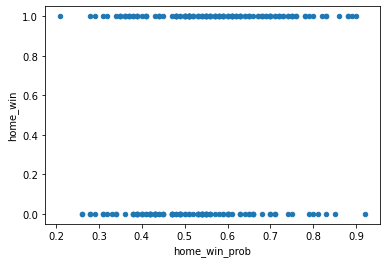

In [252]:
# Plot home win probability vs result

analysis_df.plot.scatter(x='home_win_prob', y='home_win')

      correct_preds  total_games  accuracy
week                                      
1                 6           10  0.600000
2                 7           15  0.466667
3                 9           16  0.562500
4                 8           12  0.666667
5                11           15  0.733333
6                 8           13  0.615385
7                10           13  0.769231
8                 5           13  0.384615
9                 5           11  0.454545
10                4           14  0.285714
11               10           14  0.714286
12                8           13  0.615385
13                7           11  0.636364
14                8           10  0.800000
15               10           15  0.666667
16               10           14  0.714286
17                7           10  0.700000
18                9           12  0.750000
19                4            6  0.666667
20                3            4  0.750000
21                1            1  1.000000
22         

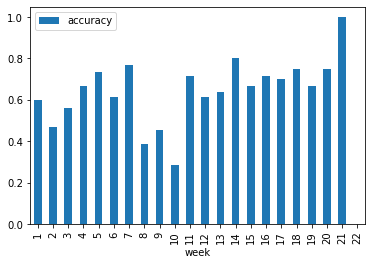

In [253]:
# Week by week accuracy

weekly = analysis_df.groupby(by='week').agg(correct_preds=('pred_correct', 'sum'), total_games=('pred_correct', 'count'))
weekly['accuracy'] = weekly.correct_preds/weekly.total_games
print(weekly)
weekly.plot.bar(y='accuracy')

In [254]:
# Average Confidence
# When correctly predicting a win, how confident were we in the prediction on average?
# Likewise, when incorrect, how confident were we?

pred_confs = analysis_df.groupby(by=['pred_correct', 'home_win']).mean()[['home_win_prob', 'away_win_prob']]
pred_confs

home_win_prob  away_win_prob
pred_correct home_win                              
0            0              0.624314       0.375686
             1              0.407143       0.592857
1            0              0.408704       0.591296
             1              0.643854       0.356146

In [255]:
# Bring in the gambling data, see how we would have fared with actual betting
# Also, compare accuracy for favorites, underdogs, etc.

betting = pd.read_csv('../data/betting_data_cleaned_with_returns.csv')
betting = betting.drop(columns=['Unnamed: 0'])

In [256]:
game_probs = base[['date', 'season', 'week', 'home', 'away', 'home_win', 'home_win_pred', 'home_win_prob', 'away_win_prob']]

In [257]:
len(game_probs)

2088

In [258]:
game_with_lines = betting.merge(game_probs, left_on=['date', 'home_team', 'away_team'], right_on=['date', 'home', 'away'])

In [259]:
game_with_lines['home_line_advantage'] = game_with_lines.apply(lambda x: x.home_win_prob-x.home_implied_prob, axis=1)
game_with_lines['away_line_advantage'] = game_with_lines.apply(lambda x: x.away_win_prob-x.away_implied_prob, axis=1)
# game_with_lines

In [291]:
def get_algo_returns(game, threshold):
    if game.home_line_advantage > game.away_line_advantage:
        bet_team = 'home'
        bet_advantage = game.home_line_advantage
    else:
        bet_team = 'away'
        bet_advantage = game.away_line_advantage
        
    if bet_advantage < threshold:
        return 0 
    
    else:
        return game['{}_return'.format(bet_team)]
    
    
threshold_var=.2
threshold = threshold_var

game_with_lines['algo_return'] = game_with_lines.apply(lambda x: get_algo_returns(x, threshold), axis=1)

In [292]:
game_with_lines

,date,home_team,away_team,home_score,away_score,total_score,home_moneyline,away_moneyline,home_spread,away_spread,total_score.1,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage,algo_return
0,2023-02-12,Philadelphia Eagles,Kansas City Chiefs,35,38,73,-120.0,100.0,-1.0,1.0,51.5,over,3,-3,away,0.545455,0.500000,away,-100.00,100.0,-100.00,100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,22,Philadelphia Eagles,Kansas City Chiefs,0,1,0.53,0.47,-0.015455,-0.030000,0.00
1,2023-01-29,Kansas City Chiefs,Cincinnati Bengals,23,20,43,-130.0,110.0,-2.0,2.0,48.5,under,-3,3,home,0.565217,0.476190,home,76.92,-100.0,76.92,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,21,Kansas City Chiefs,Cincinnati Bengals,1,1,0.68,0.32,0.114783,-0.156190,0.00
2,2023-01-22,San Francisco 49ers,Dallas Cowboys,19,12,31,-200.0,170.0,-3.5,3.5,46.5,under,-7,7,home,0.666667,0.370370,home,50.00,-100.0,50.00,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,San Francisco 49ers,Dallas Cowboys,1,1,0.73,0.27,0.063333,-0.100370,0.00
3,2023-01-22,Buffalo Bills,Cincinnati Bengals,10,27,37,-260.0,215.0,-6.0,6.0,48.5,under,17,-17,away,0.722222,0.317460,away,-100.00,215.0,-100.00,215.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,20,Buffalo Bills,Cincinnati Bengals,0,1,0.70,0.30,-0.022222,-0.017460,0.00
4,2023-01-21,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.0,26.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,Philadelphia Eagles,New York Giants,1,1,0.53,0.47,-0.261667,0.220000,-100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,2014-09-21,Cincinnati Bengals,Tennessee Titans,33,7,40,-265.0,235.0,-6.5,6.5,44.5,under,-26,26,home,0.726027,0.298507,home,37.74,-100.0,37.74,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2014,3,Cincinnati Bengals,Tennessee Titans,1,1,0.90,0.10,0.173973,-0.198507,0.00
2055,2014-09-21,Cleveland Browns,Baltimore Ravens,21,23,44,111.0,-123.0,2.0,-2.0,43.0,over,2,-2,push,0.473934,0.551570,away,81.30,-100.0,-100.00,81.30,0.00,0.00,0.00,0.00,90.91,-100.00,2014,3,Cleveland Browns,Baltimore Ravens,0,0,0.17,0.83,-0.303934,0.278430,81.30
2056,2014-09-21,New England Patriots,Las Vegas Raiders,16,9,25,-901.0,704.0,-14.0,14.0,47.5,under,-7,7,away,0.900100,0.124378,home,11.10,-100.0,11.10,-100.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2014,3,New England Patriots,Las Vegas Raiders,1,1,0.87,0.13,-0.030100,0.005622,0.00
2057,2014-09-21,Philadelphia Eagles,Washington Football Team,37,34,71,-209.0,187.0,-4.0,4.0,50.5,over,-3,3,away,0.676375,0.348432,home,47.85,-100.0,47.85,-100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2014,3,Philadelphia Eagles,Washington Football Team,1,1,0.84,0.16,0.163625,-0.188432,0.00


In [293]:
# Test Season total return

# test_with_lines = game_with_lines[game_with_lines.season != 2022]
test_with_lines = game_with_lines[game_with_lines.season == 2022]

sum(test_with_lines.algo_return)

1534.86

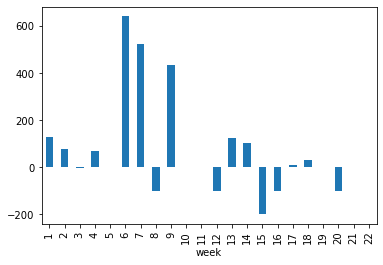

In [294]:
# Week by week return 
test_with_lines.groupby(by='week').sum()['algo_return'].plot.bar()

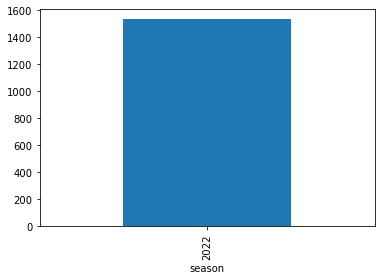

In [295]:
# Season by season return 
test_with_lines.groupby(by='season').sum()['algo_return'].plot.bar()

In [296]:
test_with_lines[test_with_lines.week == 11]

,date,home_team,away_team,home_score,away_score,total_score,home_moneyline,away_moneyline,home_spread,away_spread,total_score.1,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage,algo_return
96,2022-11-21,Arizona Cardinals,San Francisco 49ers,10,38,48,350.0,-455.0,10.0,-10.0,43.0,over,28,-28,away,0.222222,0.819820,away,21.98,-100.0,-100.00,21.98,90.91,-100.00,-100.00,90.91,90.91,-100.00,2022,11,Arizona Cardinals,San Francisco 49ers,0,0,0.26,0.74,0.037778,-0.079820,0.0
97,2022-11-20,Los Angeles Chargers,Kansas City Chiefs,27,30,57,195.0,-238.0,5.5,-5.5,53.0,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,2022,11,Los Angeles Chargers,Kansas City Chiefs,0,0,0.28,0.72,-0.058983,0.015858,0.0
98,2022-11-20,Minnesota Vikings,Dallas Cowboys,3,40,43,110.0,-132.0,2.0,-2.0,48.5,under,37,-37,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,2022,11,Minnesota Vikings,Dallas Cowboys,0,0,0.44,0.56,-0.036190,-0.008966,0.0
99,2022-11-20,Pittsburgh Steelers,Cincinnati Bengals,30,37,67,160.0,-182.0,3.5,-3.5,39.5,over,7,-7,away,0.384615,0.645390,away,54.95,-100.0,-100.00,54.95,90.91,-100.00,-100.00,90.91,90.91,-100.00,2022,11,Pittsburgh Steelers,Cincinnati Bengals,0,0,0.38,0.62,-0.004615,-0.025390,0.0
100,2022-11-20,Denver Broncos,Las Vegas Raiders,16,22,38,-152.0,130.0,-2.5,2.5,41.5,under,6,-6,away,0.603175,0.434783,away,-100.00,130.0,-100.00,130.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,11,Denver Broncos,Las Vegas Raiders,0,1,0.60,0.40,-0.003175,-0.034783,0.0
101,2022-11-20,Atlanta Falcons,Chicago Bears,27,24,51,-141.0,120.0,-2.5,2.5,48.5,over,-3,3,home,0.585062,0.454545,home,70.92,-100.0,70.92,-100.00,90.91,-100.00,90.91,-100.00,90.91,-100.00,2022,11,Atlanta Falcons,Chicago Bears,1,0,0.41,0.59,-0.175062,0.135455,0.0
102,2022-11-20,Baltimore Ravens,Carolina Panthers,13,3,16,-714.0,500.0,-12.5,12.5,41.5,under,-10,10,away,0.877150,0.166667,home,14.01,-100.0,14.01,-100.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,11,Baltimore Ravens,Carolina Panthers,1,1,0.83,0.17,-0.047150,0.003333,0.0
103,2022-11-20,Buffalo Bills,Cleveland Browns,31,23,54,-370.0,290.0,-7.5,7.5,50.5,over,-8,8,home,0.787234,0.256410,home,27.03,-100.0,27.03,-100.00,90.91,-100.00,90.91,-100.00,90.91,-100.00,2022,11,Buffalo Bills,Cleveland Browns,1,1,0.75,0.25,-0.037234,-0.006410,0.0
104,2022-11-20,Houston Texans,Washington Football Team,10,23,33,140.0,-161.0,3.0,-3.0,41.0,under,13,-13,away,0.416667,0.616858,away,62.11,-100.0,-100.00,62.11,90.91,-100.00,-100.00,90.91,-100.00,90.91,2022,11,Houston Texans,Washington Football Team,0,1,0.52,0.48,0.103333,-0.136858,0.0
105,2022-11-20,Indianapolis Colts,Philadelphia Eagles,16,17,33,240.0,-303.0,6.0,-6.0,45.0,under,1,-1,home,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,2022,11,Indianapolis Colts,Philadelphia Eagles,0,0,0.31,0.69,0.015882,-0.061861,0.0


In [297]:
# Should move these to helper functions later

def get_algo_returns_home(game, threshold):
    if game.home_line_advantage < threshold:
        return 0 
    
    else:
        return game.home_return
    
def get_algo_returns_away(game, threshold):
    if game.away_line_advantage < threshold:
        return 0 
    
    else:
        return game.away_return
    
def get_algo_returns_favorite(game, threshold):
    if game.home_moneyline < game.away_moneyline:
        favorite = 'home'
    else:
        favorite = 'away'
        
    if game['{}_line_advantage'.format(favorite)] < threshold:
        return 0 
    
    else:
        return game.favorite_return 
    
def get_algo_returns_underdog(game, threshold):
    if game.home_moneyline > game.away_moneyline:
        underdog = 'home'
    else:
        underdog = 'away'
        
    if game['{}_line_advantage'.format(underdog)] < threshold:
        return 0 
    
    else:
        return game.underdog_return 
    
threshold = threshold_var

test_with_lines['algo_return_home'] = test_with_lines.apply(lambda x: get_algo_returns_home(x, threshold), axis=1)
test_with_lines['algo_return_away'] = test_with_lines.apply(lambda x: get_algo_returns_away(x, threshold), axis=1)
test_with_lines['algo_return_favorite'] = test_with_lines.apply(lambda x: get_algo_returns_favorite(x, threshold), axis=1)
test_with_lines['algo_return_underdog'] = test_with_lines.apply(lambda x: get_algo_returns_underdog(x, threshold), axis=1)
test_with_lines

<ipython-input-297-ab0bcc3cdc1c>:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-297-ab0bcc3cdc1c>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-297-ab0bcc3cdc1c>:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-297-

,date,home_team,away_team,home_score,away_score,total_score,home_moneyline,away_moneyline,home_spread,away_spread,total_score.1,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage,algo_return,algo_return_home,algo_return_away,algo_return_favorite,algo_return_underdog
0,2023-02-12,Philadelphia Eagles,Kansas City Chiefs,35,38,73,-120.0,100.0,-1.0,1.0,51.5,over,3,-3,away,0.545455,0.500000,away,-100.00,100.0,-100.00,100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,22,Philadelphia Eagles,Kansas City Chiefs,0,1,0.53,0.47,-0.015455,-0.030000,0.0,0.0,0.0,0.0,0.0
1,2023-01-29,Kansas City Chiefs,Cincinnati Bengals,23,20,43,-130.0,110.0,-2.0,2.0,48.5,under,-3,3,home,0.565217,0.476190,home,76.92,-100.0,76.92,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,21,Kansas City Chiefs,Cincinnati Bengals,1,1,0.68,0.32,0.114783,-0.156190,0.0,0.0,0.0,0.0,0.0
2,2023-01-22,San Francisco 49ers,Dallas Cowboys,19,12,31,-200.0,170.0,-3.5,3.5,46.5,under,-7,7,home,0.666667,0.370370,home,50.00,-100.0,50.00,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,San Francisco 49ers,Dallas Cowboys,1,1,0.73,0.27,0.063333,-0.100370,0.0,0.0,0.0,0.0,0.0
3,2023-01-22,Buffalo Bills,Cincinnati Bengals,10,27,37,-260.0,215.0,-6.0,6.0,48.5,under,17,-17,away,0.722222,0.317460,away,-100.00,215.0,-100.00,215.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,20,Buffalo Bills,Cincinnati Bengals,0,1,0.70,0.30,-0.022222,-0.017460,0.0,0.0,0.0,0.0,0.0
4,2023-01-21,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.0,26.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,Philadelphia Eagles,New York Giants,1,1,0.53,0.47,-0.261667,0.220000,-100.0,0.0,-100.0,0.0,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2022-09-11,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,2022,1,Chicago Bears,San Francisco 49ers,1,1,0.51,0.49,0.206970,-0.250933,230.0,230.0,0.0,0.0,230.0
238,2022-09-11,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,2022,1,Detroit Lions,Philadelphia Eagles,0,1,0.63,0.37,0.291017,-0.334142,-100.0,-100.0,0.0,0.0,-100.0
239,2022-09-11,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,1,Miami Dolphins,New England Patriots,1,1,0.62,0.38,-0.012353,-0.020000,0.0,0.0,0.0,0.0,0.0
240,2022-09-11,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,2022,1,New York Jets,Baltimore Ravens,0,0,0.39,0.61,0.095882,-0.141861,0.0,0.0,0.0,0.0,0.0


In [298]:
# Look at outcomes by home, away, favorite, underdog, etc.

test_pivoted = test_with_lines.copy().reset_index()
test_pivoted = test_pivoted.groupby(by='week').sum().reset_index()
test_pivoted = pd.melt(test_pivoted, id_vars = ['week'],
              value_vars=['algo_return_home', 'algo_return_away', 'algo_return_favorite', 'algo_return_underdog'],
             var_name='algo_return_type', value_name='return')
test_pivoted

,week,algo_return_type,return
0,1,algo_return_home,130.0
1,2,algo_return_home,275.0
2,3,algo_return_home,-100.0
3,4,algo_return_home,0.0
4,5,algo_return_home,0.0
...,...,...,...
83,18,algo_return_underdog,30.0
84,19,algo_return_underdog,0.0
85,20,algo_return_underdog,-100.0
86,21,algo_return_underdog,0.0


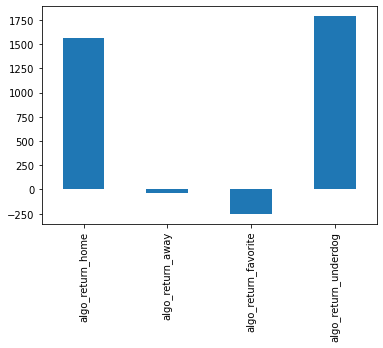

In [299]:
test_with_lines.sum()[['algo_return_home', 'algo_return_away', 'algo_return_favorite', 'algo_return_underdog']].plot.bar()

In [300]:
# Week by week return 

fig = px.bar(test_pivoted, x="week", y="return", color='algo_return_type')
fig.show()

In [301]:
# Get accuracies 

def get_algo_acc(game, column):
    if game[column] > 0:
        return 1
    elif game[column] < 0:
        return 0 
    else:
        return None

test_with_lines['algo_home_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_home'), axis=1)
test_with_lines['algo_away_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_away'), axis=1)
test_with_lines['algo_favorite_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_favorite'), axis=1)
test_with_lines['algo_underdog_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_underdog'), axis=1)
test_with_lines

<ipython-input-301-3ec925f5dcd9>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-301-3ec925f5dcd9>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-301-3ec925f5dcd9>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-301-

,date,home_team,away_team,home_score,away_score,total_score,home_moneyline,away_moneyline,home_spread,away_spread,total_score.1,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage,algo_return,algo_return_home,algo_return_away,algo_return_favorite,algo_return_underdog,algo_home_acc,algo_away_acc,algo_favorite_acc,algo_underdog_acc
0,2023-02-12,Philadelphia Eagles,Kansas City Chiefs,35,38,73,-120.0,100.0,-1.0,1.0,51.5,over,3,-3,away,0.545455,0.500000,away,-100.00,100.0,-100.00,100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,22,Philadelphia Eagles,Kansas City Chiefs,0,1,0.53,0.47,-0.015455,-0.030000,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2023-01-29,Kansas City Chiefs,Cincinnati Bengals,23,20,43,-130.0,110.0,-2.0,2.0,48.5,under,-3,3,home,0.565217,0.476190,home,76.92,-100.0,76.92,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,21,Kansas City Chiefs,Cincinnati Bengals,1,1,0.68,0.32,0.114783,-0.156190,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2023-01-22,San Francisco 49ers,Dallas Cowboys,19,12,31,-200.0,170.0,-3.5,3.5,46.5,under,-7,7,home,0.666667,0.370370,home,50.00,-100.0,50.00,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,San Francisco 49ers,Dallas Cowboys,1,1,0.73,0.27,0.063333,-0.100370,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2023-01-22,Buffalo Bills,Cincinnati Bengals,10,27,37,-260.0,215.0,-6.0,6.0,48.5,under,17,-17,away,0.722222,0.317460,away,-100.00,215.0,-100.00,215.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,20,Buffalo Bills,Cincinnati Bengals,0,1,0.70,0.30,-0.022222,-0.017460,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2023-01-21,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.0,26.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,Philadelphia Eagles,New York Giants,1,1,0.53,0.47,-0.261667,0.220000,-100.0,0.0,-100.0,0.0,-100.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2022-09-11,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,2022,1,Chicago Bears,San Francisco 49ers,1,1,0.51,0.49,0.206970,-0.250933,230.0,230.0,0.0,0.0,230.0,1.0,NaN,NaN,1.0
238,2022-09-11,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,2022,1,Detroit Lions,Philadelphia Eagles,0,1,0.63,0.37,0.291017,-0.334142,-100.0,-100.0,0.0,0.0,-100.0,0.0,NaN,NaN,0.0
239,2022-09-11,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,1,Miami Dolphins,New England Patriots,1,1,0.62,0.38,-0.012353,-0.020000,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
240,2022-09-11,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,2022,1,New York Jets,Baltimore Ravens,0,0,0.39,0.61,0.095882,-0.141861,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [302]:
accs = test_with_lines.groupby(by='week').agg(
    algo_home_correct = ('algo_home_acc', 'sum'),
    algo_home_total = ('algo_home_acc', 'count'),
    algo_away_correct = ('algo_away_acc', 'sum'),
    algo_away_total = ('algo_away_acc', 'count'),
    algo_favorite_correct = ('algo_favorite_acc', 'sum'),
    algo_favorite_total = ('algo_favorite_acc', 'count'),
    algo_underdog_correct = ('algo_underdog_acc', 'sum'),
    algo_underdog_total = ('algo_underdog_acc', 'count')
)

accs['algo_home_acc'] = accs.algo_home_correct/accs.algo_home_total
accs['algo_away_acc'] = accs.algo_away_correct/accs.algo_away_total
accs['algo_favorite_acc'] = accs.algo_favorite_correct/accs.algo_favorite_total
accs['algo_underdog_acc'] = accs.algo_underdog_correct/accs.algo_underdog_total

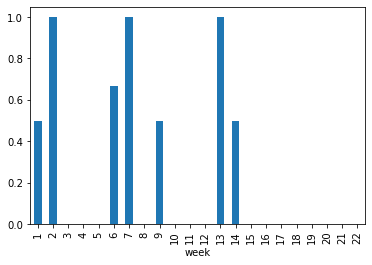

In [303]:
check_col = 'algo_home_acc'
accs[check_col].plot.bar()

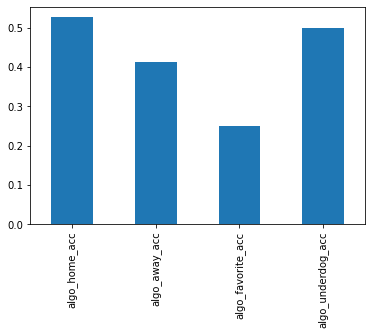

In [304]:
accs2 = test_with_lines.agg(['sum','count']).transpose().loc[['algo_home_acc', 'algo_away_acc', 'algo_favorite_acc', 'algo_underdog_acc']]
accs2['accuracy'] = accs2['sum']/accs2['count']
accs2.accuracy.plot.bar()

In [305]:
# Total bet counts

len(test_with_lines[test_with_lines.algo_return != 0])

36

In [306]:
test_with_lines[test_with_lines.algo_return!=0][['date', 'week', 'home_team', 'away_team', 'home_score', 'away_score', 'algo_return', 'home_line_advantage', 'away_line_advantage']]

,date,week,home_team,away_team,home_score,away_score,algo_return,home_line_advantage,away_line_advantage
4,2023-01-21,20,Philadelphia Eagles,New York Giants,38,7,-100.00,-0.261667,0.220000
12,2023-01-08,18,Green Bay Packers,Detroit Lions,16,20,195.00,-0.321493,0.281017
15,2023-01-08,18,Denver Broncos,Los Angeles Chargers,31,28,-100.00,-0.386842,0.346970
16,2023-01-08,18,Indianapolis Colts,Houston Texans,31,32,135.00,-0.277843,0.244468
17,2023-01-08,18,Miami Dolphins,New York Jets,11,6,-100.00,-0.279123,0.252642
22,2023-01-07,18,Las Vegas Raiders,Kansas City Chiefs,13,31,-100.00,0.314706,-0.359886
31,2023-01-01,17,Tampa Bay Buccaneers,Carolina Panthers,30,24,-100.00,-0.299123,0.272642
32,2023-01-01,17,Washington Football Team,Cleveland Browns,10,24,110.00,-0.275217,0.233810
39,2022-12-24,16,Carolina Panthers,Detroit Lions,37,23,-100.00,-0.255116,0.215532
47,2022-12-19,15,Green Bay Packers,Los Angeles Rams,24,12,-100.00,-0.287234,0.243590


In [307]:
# NOTE

do some eda, maybe 6 games isnt the best number
maybe would be good to use previous season data for the early weeks as well
can look at autocorrelation? see how the correlation between stats changes the farther the number of games is
may find that after 4 or 5 games the correlation gets very small, or maybe the opposite

SyntaxError: invalid syntax (<ipython-input-307-f9b5b14d5471>, line 3)